# Ex12 다음에 볼 영화 예측하기

## 프로젝트 개요

* Moivelens 1M Dataset을 기반으로 Session based Recommendation 시스템 제작

In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.


### 데이터 특징

* 여기서 이전 실습내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다는 점입니다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.

* Rating 정보가 포함되어 있습니다. 이전 실습내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 하지만, 직전에 봤던 영화가 맘에 들었는지 여부가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.

* Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초단위 시간이 기재되어 있습니다.

In [2]:
data.head(20)

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
36,1,1836,5,978300172
3,1,3408,4,978300275
7,1,2804,5,978300719
47,1,1207,4,978300719
0,1,1193,5,978300760


### 시간이 잘 구분이 안되 표준 시간으로 변경해보겠습니다.

In [3]:
data['UnitTime']=pd.to_datetime(data['Time'],unit='s')

In [4]:
data.head(50)

,UserId,ItemId,Rating,Time,UnitTime
31,1,3186,4,978300019,2000-12-31 22:00:19
22,1,1270,5,978300055,2000-12-31 22:00:55
27,1,1721,4,978300055,2000-12-31 22:00:55
37,1,1022,5,978300055,2000-12-31 22:00:55
24,1,2340,3,978300103,2000-12-31 22:01:43
36,1,1836,5,978300172,2000-12-31 22:02:52
3,1,3408,4,978300275,2000-12-31 22:04:35
7,1,2804,5,978300719,2000-12-31 22:11:59
47,1,1207,4,978300719,2000-12-31 22:11:59
0,1,1193,5,978300760,2000-12-31 22:12:40


### session은 접속해서 연속으로 둘러본 데이터를 의미합니다. 따라서 한번접속해서 연속으로 본 경우에 따라 세션아이디를 부여해야합니다. 그러나 User id 1,2,3의 데이터를 보니 그 기준을 시간, 분, 초로 하기에는 애매했습니다. 그래서 1일을 기준으로 세션 아이디를 부여했습니다. 

In [5]:
data[data['UserId']==1]

,UserId,ItemId,Rating,Time,UnitTime
31,1,3186,4,978300019,2000-12-31 22:00:19
22,1,1270,5,978300055,2000-12-31 22:00:55
27,1,1721,4,978300055,2000-12-31 22:00:55
37,1,1022,5,978300055,2000-12-31 22:00:55
24,1,2340,3,978300103,2000-12-31 22:01:43
36,1,1836,5,978300172,2000-12-31 22:02:52
3,1,3408,4,978300275,2000-12-31 22:04:35
7,1,2804,5,978300719,2000-12-31 22:11:59
47,1,1207,4,978300719,2000-12-31 22:11:59
0,1,1193,5,978300760,2000-12-31 22:12:40


In [6]:
data[data['UserId']==2]

,UserId,ItemId,Rating,Time,UnitTime
130,2,1198,4,978298124,2000-12-31 21:28:44
64,2,1210,4,978298151,2000-12-31 21:29:11
71,2,1217,3,978298151,2000-12-31 21:29:11
134,2,2717,3,978298196,2000-12-31 21:29:56
88,2,1293,5,978298261,2000-12-31 21:31:01
...,...,...,...,...,...
133,2,95,2,978300143,2000-12-31 22:02:23
66,2,1687,3,978300174,2000-12-31 22:02:54
73,2,434,2,978300174,2000-12-31 22:02:54
87,2,1544,4,978300174,2000-12-31 22:02:54


In [7]:
data[data['UserId']==3]

,UserId,ItemId,Rating,Time,UnitTime
217,3,593,3,978297018,2000-12-31 21:10:18
202,3,2858,4,978297039,2000-12-31 21:10:39
186,3,3534,3,978297068,2000-12-31 21:11:08
230,3,1968,4,978297068,2000-12-31 21:11:08
190,3,1431,3,978297095,2000-12-31 21:11:35
225,3,1961,4,978297095,2000-12-31 21:11:35
209,3,1266,5,978297396,2000-12-31 21:16:36
216,3,1378,5,978297419,2000-12-31 21:16:59
218,3,1379,4,978297419,2000-12-31 21:16:59
226,3,3671,5,978297419,2000-12-31 21:16:59


In [8]:
import time
from tqdm import tqdm

In [9]:
session_id = []

pre_time = 0
pre_user = 0
session = 0



for cur_data in tqdm(data.iloc):
    if cur_data['Time'] - pre_time > 86400 or pre_user != cur_data['UserId']:
        session += 1
    pre_time = cur_data['Time']
    pre_user = cur_data['UserId']
    session_id.append(session)
  


data['SessionId'] = session_id

1000209it [03:57, 4212.88it/s]


### user Id가 다르거나 하루가지났을경우 session아이디를 새로부여했습니다.

In [10]:
data[data['UserId']==1]

,UserId,ItemId,Rating,Time,UnitTime,SessionId
31,1,3186,4,978300019,2000-12-31 22:00:19,1
22,1,1270,5,978300055,2000-12-31 22:00:55,1
27,1,1721,4,978300055,2000-12-31 22:00:55,1
37,1,1022,5,978300055,2000-12-31 22:00:55,1
24,1,2340,3,978300103,2000-12-31 22:01:43,1
36,1,1836,5,978300172,2000-12-31 22:02:52,1
3,1,3408,4,978300275,2000-12-31 22:04:35,1
7,1,2804,5,978300719,2000-12-31 22:11:59,1
47,1,1207,4,978300719,2000-12-31 22:11:59,1
0,1,1193,5,978300760,2000-12-31 22:12:40,1


###  세션수 아이템수 확인

In [11]:
data['SessionId'].nunique(), data['ItemId'].nunique()

(20716, 3706)

### 세션 길이 확인

In [12]:
session_length = data.groupby('SessionId').size()
session_length.head(10)

SessionId
1      40
2      13
3     129
4      51
5      21
6     198
7      71
8      31
9     139
10    106
dtype: int64

In [13]:
session_length.median(), session_length.mean()

(7.0, 48.281955976057155)

In [14]:
session_length.min(), session_length.max()

(1, 1849)

In [15]:
session_length.quantile(0.999)

903.4150000000664

In [16]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

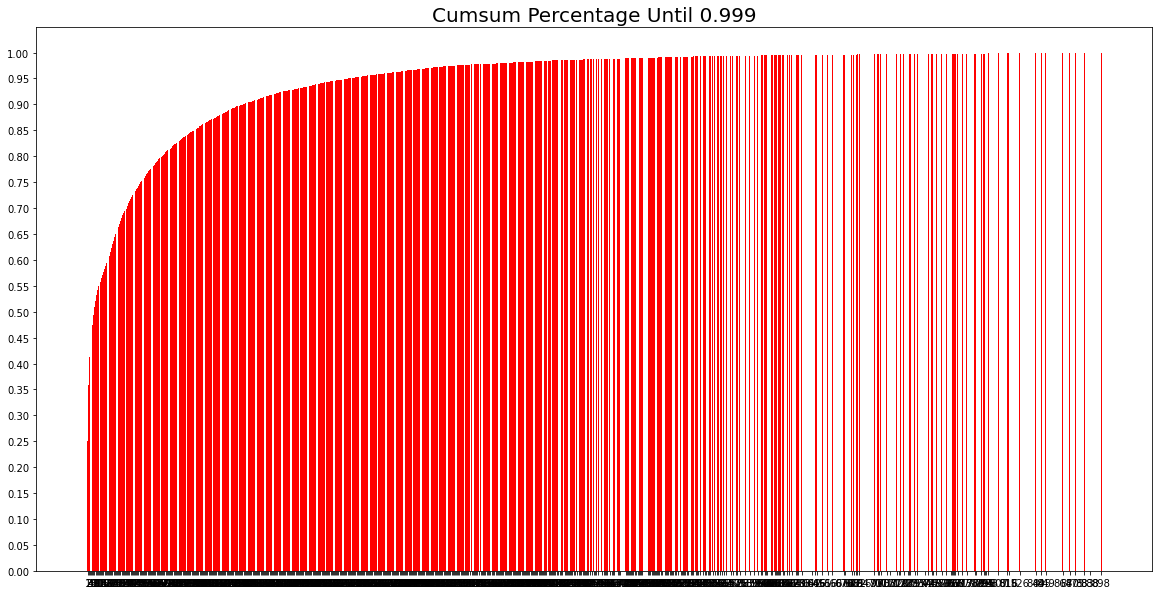

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [18]:
oldest = data['UnitTime'].min()
latest = data['UnitTime'].max()
print(oldest)
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [19]:
year_ago = latest - dt.timedelta(365)     # 최종 날짜로부터 1년 이전 날짜를 구한다.  
data = data[data['UnitTime'] > year_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
data

,UserId,ItemId,Rating,Time,UnitTime,SessionId
5170,36,1387,5,1015904819,2002-03-12 03:46:59,70
5267,36,1201,4,1015904819,2002-03-12 03:46:59,70
5122,36,1291,5,1015904836,2002-03-12 03:47:16,70
5123,36,2167,5,1015904905,2002-03-12 03:48:25,70
5290,36,2951,4,1015904905,2002-03-12 03:48:25,70
...,...,...,...,...,...,...
992358,5996,3835,3,1020113184,2002-04-29 20:46:24,20623
992279,5996,2422,3,1020113225,2002-04-29 20:47:05,20623
992702,5996,168,3,1031058746,2002-09-03 13:12:26,20624
992459,5996,339,4,1033997079,2002-10-07 13:24:39,20625


In [20]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [21]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data.shape

(17073, 6)

### 테스트데이터: 최근1개월, 검증데이터:전 2개월 데이터, 훈련데이터: 2개월전 데이터로 설정

In [22]:
train_ago = latest - dt.timedelta(60)
train = data[data['UnitTime'] <= train_ago]

test_ago = latest - dt.timedelta(30)
test = data[data['UnitTime'] >= test_ago]

val=data[(train_ago<data['UnitTime'])&(data['UnitTime']<test_ago)]

In [23]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(train['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

train = indexing(train, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [24]:
train

,UserId,ItemId,Rating,Time,UnitTime,SessionId,item_idx
5170,36,1387,5,1015904819,2002-03-12 03:46:59,70,0
5267,36,1201,4,1015904819,2002-03-12 03:46:59,70,1
5122,36,1291,5,1015904836,2002-03-12 03:47:16,70,2
5123,36,2167,5,1015904905,2002-03-12 03:48:25,70,3
5290,36,2951,4,1015904905,2002-03-12 03:48:25,70,4
...,...,...,...,...,...,...,...
992689,5996,2701,3,1020111976,2002-04-29 20:26:16,20623,1000
992304,5996,2471,2,1020112109,2002-04-29 20:28:29,20623,760
992466,5996,3564,3,1020112392,2002-04-29 20:33:12,20623,628
992358,5996,3835,3,1020113184,2002-04-29 20:46:24,20623,1338


In [25]:

save_path = data_path / 'processed2'
save_path.mkdir(parents=True, exist_ok = True)

train.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## 미니배치 구성 

In [26]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [27]:
train_dataset = SessionDataset(train)
train_dataset.df.head(10)

,UserId,ItemId,Rating,Time,UnitTime,SessionId,item_idx
5170,36,1387,5,1015904819,2002-03-12 03:46:59,70,0
5267,36,1201,4,1015904819,2002-03-12 03:46:59,70,1
5122,36,1291,5,1015904836,2002-03-12 03:47:16,70,2
5123,36,2167,5,1015904905,2002-03-12 03:48:25,70,3
5290,36,2951,4,1015904905,2002-03-12 03:48:25,70,4
5359,36,2115,5,1015904905,2002-03-12 03:48:25,70,5
5073,36,1912,5,1015904924,2002-03-12 03:48:44,70,6
5113,36,2662,3,1015904924,2002-03-12 03:48:44,70,7
5366,36,2985,4,1015904941,2002-03-12 03:49:01,70,8
5145,36,198,5,1015904988,2002-03-12 03:49:48,70,9


In [28]:
train_dataset.click_offsets

array([    0,    17,    30, ..., 14238, 14245, 14355], dtype=int32)

In [29]:
train_dataset.session_idx

array([   0,    1,    2, ..., 1166, 1167, 1168])

In [30]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=16):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [31]:
train_data_loader = SessionDataLoader(train_dataset, batch_size=4)
train_dataset.df.head(15)

,UserId,ItemId,Rating,Time,UnitTime,SessionId,item_idx
5170,36,1387,5,1015904819,2002-03-12 03:46:59,70,0
5267,36,1201,4,1015904819,2002-03-12 03:46:59,70,1
5122,36,1291,5,1015904836,2002-03-12 03:47:16,70,2
5123,36,2167,5,1015904905,2002-03-12 03:48:25,70,3
5290,36,2951,4,1015904905,2002-03-12 03:48:25,70,4
5359,36,2115,5,1015904905,2002-03-12 03:48:25,70,5
5073,36,1912,5,1015904924,2002-03-12 03:48:44,70,6
5113,36,2662,3,1015904924,2002-03-12 03:48:44,70,7
5366,36,2985,4,1015904941,2002-03-12 03:49:01,70,8
5145,36,198,5,1015904988,2002-03-12 03:49:48,70,9


In [32]:
iter_ex = iter(train_data_loader)

In [33]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 17 30 33]
Label Item Idx are :       [ 1 18 31 34]
Previous Masked Input Idx are []


## 모델 구성

In [34]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [35]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


In [36]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [37]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(train, val, test, batch_size=32, hsz=50, drop_rate=0.1, lr=0.005, epochs=20, k=20)

In [38]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(32, 1, 1443)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      224250    
_________________________________________________________________
dropout (Dropout)            (32, 50)                  0         
_________________________________________________________________
dense (Dense)                (32, 1443)                73593     
Total params: 297,843
Trainable params: 297,843
Non-trainable params: 0
_________________________________________________________________


## 모델학습

In [39]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

## 개선하기

### 1. session 정의 수정
* 첫 시도는 userId를 session 아이디로 그대로 사용했습니다. accuracy와 loss의 추이를 보면 학습이 잘되지않았습니다.
* 그래서 세밀한 데이터를 보기위해 session아이디를 나누는 기준을 하루로 기준을 변경했습니다. 

### 2. 파라미터 세팅1
* batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epoch=10, k=20으로 첫 세팅을 했습니다.

In [40]:
args = Args(train, val, test, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)
model = create_model(args)
train_model(model, args)

Train:   0%|          | 0/412 [00:00<?, ?it/s]

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(32, 1, 1443)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      224250    
_________________________________________________________________
dropout_1 (Dropout)          (32, 50)                  0         
_________________________________________________________________
dense_1 (Dense)              (32, 1443)                73593     
Total params: 297,843
Trainable params: 297,843
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0, train_loss=7.03]     

	 - Recall@20 epoch 1: 0.057692
	 - MRR@20    epoch 1: 0.009961



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0, train_loss=7.12]     

	 - Recall@20 epoch 2: 0.048077
	 - MRR@20    epoch 2: 0.008689



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0, train_loss=6.94]     

	 - Recall@20 epoch 3: 0.057692
	 - MRR@20    epoch 3: 0.011286



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0, train_loss=7.02]     

	 - Recall@20 epoch 4: 0.055288
	 - MRR@20    epoch 4: 0.013223



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.79]

	 - Recall@20 epoch 5: 0.060096
	 - MRR@20    epoch 5: 0.015051



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0.0625, train_loss=6.65]

	 - Recall@20 epoch 6: 0.050481
	 - MRR@20    epoch 6: 0.016543



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.5] 

	 - Recall@20 epoch 7: 0.062500
	 - MRR@20    epoch 7: 0.017666



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0.0625, train_loss=6.31]

	 - Recall@20 epoch 8: 0.072115
	 - MRR@20    epoch 8: 0.016976



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0, train_loss=6.45]     

	 - Recall@20 epoch 9: 0.064904
	 - MRR@20    epoch 9: 0.015191



Evaluation:  32%|███▏      | 13/41 [00:03<00:06,  4.30it/s]

	 - Recall@20 epoch 10: 0.079327
	 - MRR@20    epoch 10: 0.016461



In [41]:
test_model(model, args, test)

Evaluation:  19%|█▉        | 7/37 [00:01<00:06,  4.31it/s]

	 - Recall@20: 0.049107
	 - MRR@20: 0.014036



* 정확도와 훈련loss가 안정적으로 수렴하지않았습니다. 

### 파라미터 세팅2
* 세팅 1에서는 정확도와 훈련로스가 변경이 되지않았습니다.
* 학습에 가장 영향을 많이주는 하이퍼파라미터가 learning rate라고 들어서 learning rate를 올려봤습니다.
* batch_size=32, hsz=50, drop_rate=0.1, lr=0.005, epoch=10, k=20으로 첫 세팅을 했습니다.

In [42]:
args = Args(train, val, test, batch_size=32, hsz=50, drop_rate=0.1, lr=0.005, epochs=10, k=20)
model = create_model(args)
train_model(model, args)

Train:   0%|          | 0/412 [00:00<?, ?it/s]

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(32, 1, 1443)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      224250    
_________________________________________________________________
dropout_2 (Dropout)          (32, 50)                  0         
_________________________________________________________________
dense_2 (Dense)              (32, 1443)                73593     
Total params: 297,843
Trainable params: 297,843
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0, train_loss=6.78]     

	 - Recall@20 epoch 1: 0.060096
	 - MRR@20    epoch 1: 0.012137



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0, train_loss=6.83]     

	 - Recall@20 epoch 2: 0.060096
	 - MRR@20    epoch 2: 0.015512



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.83]

	 - Recall@20 epoch 3: 0.108173
	 - MRR@20    epoch 3: 0.025492



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.89] 

	 - Recall@20 epoch 4: 0.110577
	 - MRR@20    epoch 4: 0.026992



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0.156, train_loss=4.09] 

	 - Recall@20 epoch 5: 0.120192
	 - MRR@20    epoch 5: 0.030763



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0.281, train_loss=3.48]

	 - Recall@20 epoch 6: 0.103365
	 - MRR@20    epoch 6: 0.031724



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0.344, train_loss=2.77]

	 - Recall@20 epoch 7: 0.110577
	 - MRR@20    epoch 7: 0.027356



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0.438, train_loss=2.33]

	 - Recall@20 epoch 8: 0.103365
	 - MRR@20    epoch 8: 0.026909



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0.375, train_loss=2.48]

	 - Recall@20 epoch 9: 0.100962
	 - MRR@20    epoch 9: 0.024526



Evaluation:  32%|███▏      | 13/41 [00:02<00:06,  4.38it/s]

	 - Recall@20 epoch 10: 0.100962
	 - MRR@20    epoch 10: 0.022154



In [43]:
test_model(model, args, test)

Evaluation:  19%|█▉        | 7/37 [00:01<00:07,  4.27it/s]

	 - Recall@20: 0.044643
	 - MRR@20: 0.026662



* 정확도와 훈련 loss가 좋아지는 것을 보았으나 더 올릴 수 있어보입니다.

### 파라미터 세팅3
* 세팅 2에서는 정확도와 훈련 loss가 좋아지는 것을 보였으나 에폭이 부족해 더 좋아지는것을 못본거 같습니다.
* batch_size=32, hsz=50, drop_rate=0.1, lr=0.005, epoch=20, k=20으로 첫 세팅을 했습니다.

In [44]:
args = Args(train, val, test, batch_size=32, hsz=50, drop_rate=0.1, lr=0.005, epochs=20, k=20)
model = create_model(args)
train_model(model, args)

Train:   0%|          | 0/412 [00:00<?, ?it/s]

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(32, 1, 1443)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      224250    
_________________________________________________________________
dropout_3 (Dropout)          (32, 50)                  0         
_________________________________________________________________
dense_3 (Dense)              (32, 1443)                73593     
Total params: 297,843
Trainable params: 297,843
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0, train_loss=6.95]     

	 - Recall@20 epoch 1: 0.057692
	 - MRR@20    epoch 1: 0.012486



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0, train_loss=6.86]     

	 - Recall@20 epoch 2: 0.040865
	 - MRR@20    epoch 2: 0.007945



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.18]

	 - Recall@20 epoch 3: 0.074519
	 - MRR@20    epoch 3: 0.014819



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.2] 

	 - Recall@20 epoch 4: 0.079327
	 - MRR@20    epoch 4: 0.024965



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0.156, train_loss=4.38] 

	 - Recall@20 epoch 5: 0.091346
	 - MRR@20    epoch 5: 0.023675



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0.312, train_loss=3.05] 

	 - Recall@20 epoch 6: 0.093750
	 - MRR@20    epoch 6: 0.022860



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0.312, train_loss=2.55] 

	 - Recall@20 epoch 7: 0.091346
	 - MRR@20    epoch 7: 0.023120



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0.344, train_loss=2.65]

	 - Recall@20 epoch 8: 0.086538
	 - MRR@20    epoch 8: 0.022650



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0.25, train_loss=2.45] 

	 - Recall@20 epoch 9: 0.091346
	 - MRR@20    epoch 9: 0.021314



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0.469, train_loss=1.75]

	 - Recall@20 epoch 10: 0.086538
	 - MRR@20    epoch 10: 0.019908



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0.5, train_loss=2.15]  

	 - Recall@20 epoch 11: 0.086538
	 - MRR@20    epoch 11: 0.019895



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0.562, train_loss=1.58]

	 - Recall@20 epoch 12: 0.079327
	 - MRR@20    epoch 12: 0.016101



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.43]

	 - Recall@20 epoch 13: 0.074519
	 - MRR@20    epoch 13: 0.016999



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0.594, train_loss=1.26]

	 - Recall@20 epoch 14: 0.076923
	 - MRR@20    epoch 14: 0.015492



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0.688, train_loss=1.07]

	 - Recall@20 epoch 15: 0.081731
	 - MRR@20    epoch 15: 0.017050



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0.781, train_loss=1.05]

	 - Recall@20 epoch 16: 0.086538
	 - MRR@20    epoch 16: 0.019944



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0.656, train_loss=1.25]

	 - Recall@20 epoch 17: 0.074519
	 - MRR@20    epoch 17: 0.020226



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0.5, train_loss=1.31]   

	 - Recall@20 epoch 18: 0.079327
	 - MRR@20    epoch 18: 0.018233



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.14]

	 - Recall@20 epoch 19: 0.062500
	 - MRR@20    epoch 19: 0.017698



Evaluation:  32%|███▏      | 13/41 [00:03<00:06,  4.30it/s]

	 - Recall@20 epoch 20: 0.069712
	 - MRR@20    epoch 20: 0.015007



In [45]:
test_model(model, args, test)

Evaluation:  19%|█▉        | 7/37 [00:01<00:07,  4.27it/s]

	 - Recall@20: 0.044643
	 - MRR@20: 0.019255



* accuracy가 0.656이나오고 train loss가 1.1까지 줄어들고 훈련에서의 Recall과 MRR이 좋아진것을 볼수 있습니다.

## 모델변경하기

* activation function을 tanh로 변경해봤습니다.

In [70]:
def create_model2(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='tanh')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model



In [75]:
args = Args(train, val, test, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=20, k=20)
model = create_model2(args)
train_model(model, args)

Train:   0%|          | 0/412 [00:00<?, ?it/s]

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(32, 1, 1443)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      224250    
_________________________________________________________________
dropout_20 (Dropout)         (32, 50)                  0         
_________________________________________________________________
dense_20 (Dense)             (32, 1443)                73593     
Total params: 297,843
Trainable params: 297,843
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0, train_loss=10.8]     

	 - Recall@20 epoch 1: 0.021635
	 - MRR@20    epoch 1: 0.004174



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0, train_loss=9.6]      

	 - Recall@20 epoch 2: 0.026442
	 - MRR@20    epoch 2: 0.004297



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0, train_loss=10.5]     

	 - Recall@20 epoch 3: 0.028846
	 - MRR@20    epoch 3: 0.006055



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0.0312, train_loss=11.3]

	 - Recall@20 epoch 4: 0.028846
	 - MRR@20    epoch 4: 0.007060



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0.0312, train_loss=9.54]

	 - Recall@20 epoch 5: 0.031250
	 - MRR@20    epoch 5: 0.005219



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0, train_loss=8.4]      

	 - Recall@20 epoch 6: 0.031250
	 - MRR@20    epoch 6: 0.007522



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0, train_loss=11]       

	 - Recall@20 epoch 7: 0.038462
	 - MRR@20    epoch 7: 0.008143



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0, train_loss=11.5]     

	 - Recall@20 epoch 8: 0.036058
	 - MRR@20    epoch 8: 0.007372



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0, train_loss=9.61]     

	 - Recall@20 epoch 9: 0.036058
	 - MRR@20    epoch 9: 0.005892



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0, train_loss=9.25]     

	 - Recall@20 epoch 10: 0.038462
	 - MRR@20    epoch 10: 0.007193



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0, train_loss=10.3]     

	 - Recall@20 epoch 11: 0.038462
	 - MRR@20    epoch 11: 0.007158



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0, train_loss=11.4]     

	 - Recall@20 epoch 12: 0.038462
	 - MRR@20    epoch 12: 0.007146



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0, train_loss=9.2]      

	 - Recall@20 epoch 13: 0.040865
	 - MRR@20    epoch 13: 0.006059



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0, train_loss=9.71]    

	 - Recall@20 epoch 14: 0.040865
	 - MRR@20    epoch 14: 0.006066



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0, train_loss=11.1]

	 - Recall@20 epoch 15: 0.038462
	 - MRR@20    epoch 15: 0.006186



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0, train_loss=9.21]

	 - Recall@20 epoch 16: 0.038462
	 - MRR@20    epoch 16: 0.006197



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0, train_loss=7.91]

	 - Recall@20 epoch 17: 0.040865
	 - MRR@20    epoch 17: 0.006138



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0, train_loss=11.3]

	 - Recall@20 epoch 18: 0.040865
	 - MRR@20    epoch 18: 0.006319



Train:   0%|          | 0/412 [00:00<?, ?it/s, accuracy=0, train_loss=12.6]

	 - Recall@20 epoch 19: 0.033654
	 - MRR@20    epoch 19: 0.005893



Evaluation:  32%|███▏      | 13/41 [00:03<00:06,  4.21it/s]

	 - Recall@20 epoch 20: 0.031250
	 - MRR@20    epoch 20: 0.005625



In [76]:
test_model(model, args, test)

Evaluation:  19%|█▉        | 7/37 [00:01<00:07,  4.20it/s]

	 - Recall@20: 0.017857
	 - MRR@20: 0.002195



* 훈련이 정상적으로 진행되지 않았습니다.

## 회고

* session 정의로 데이터 전처리하는데 어려움을 느꼈습니다. dataframe을 자유롭게 다룰 수 있도록 공부해야겠습니다.
* validation 단계에서의 MRR과 recall은 좋아지는것같은데 test 단계에서는 그다지 좋아지지 않는 모습을 보여 개선이 필요해보입니다.
* 좀더 다양한 모델 변경을 하고싶었지만 시간이부족해 못했습니다.